## BackTracking
- DP와 유사
- 막히면 되돌아간다


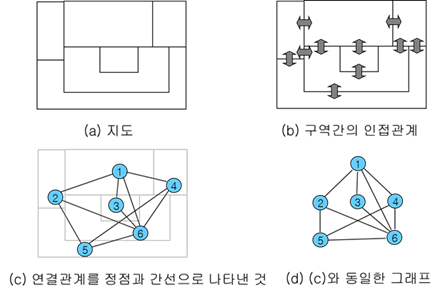

In [6]:
# coloring
my_color = {
     1:{2,3,4,6},
     2:{1,5,6},
     3:{1,6},
     4:{1,5,6},
     5:{2,4,6},
     6:{1,2,3,4,5}
}
def coloring(node, c, color_range):
  if is_valid(node, c): # c를 칠해도 된다면
    color[node] = c
    if node == len(my_color): # 끝
      return True
    result = False
    c_key = 1
    while result == False and c_key <= color_range:
      result = coloring(node+1, c_key, color_range)
      # 다음 노드도 같은 색으로 칠한다
      c_key += 1
      # 색 변경 (같은색으로 칠하는 중첩 while문 빠져나오면)
    return result
  else:
    return False

def is_valid(node, c):
  for i in range(1, node):
    if i in my_color[node] and color[i] == c:
      # 옆에 있는 노드인데, 색이 같으면
      return False
  return True

for k in range(1, 6):
  color = {}
  print(coloring(1, 1, k))
  print(k, color)


False
1 {1: 1}
False
2 {1: 1, 2: 2, 3: 2, 4: 2, 5: 1}
True
3 {1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 3}
True
4 {1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 3}
True
5 {1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 3}


## Branch & Bound
- backtracking과 유사하나, 최적해 찾을 가능성이 없으면 분기하지 않는다
- 해당 시점의 min값을 통해 최적해 가능성을 추정한다

- 현재까지의 cost + 미래의 최소 cost (future cost)의 합이 낮은 node를 먼저 방문한다.
- 이것이 bound값보다 크면, 무시한다.

In [67]:
import sys

t = [
    [ 0, 10, 10, 30, 25],
    [10,  0, 14, 21, 10],
    [10, 18,  0,  7,  9],
    [ 8, 11,  7,  0,  3],
    [14, 10, 10,  3,  0]
]
bound = sys.maxsize

def bnb(node, visited=[], cost=0):
    visited = visited.copy() # 다른 분기의 vistied가 영향받지 않도록
    global bound
    future_cost = get_future_cost(visited)
    # 앞으로 가야하는 최소 cost
    if cost+future_cost > bound:
        # cost가 bound보다 높아진다면 return
        print('Bound:', visited, node, cost+future_cost)
        return

    visited.append(node)
    # future cost 계산 이후 visited에 추가하는 이유는?
    # 지금 추가하는 node도 앞으로 가는 경로를 추정해야하기 때문.
    
    if len(visited) == len(t):
        # 모두 다 방문했다면, 첫번째로 돌아간다.
        visited.append(visited[0])
        cost += t[node][visited[0]]
        print('Final:', visited, cost)
        bound = min(bound, cost)
        return
    
    sorted_t = sorted(enumerate(t[node]), key=lambda x:x[1])
    # (idx, cost)의 배열꼴로 다음 경로 cost 리스트를 생성
    for new, add_cost in sorted_t:
        if new not in visited:
            # 방문하지 않은 new node를 방문한다
            # 이 때 간선의 비용을 누적한다
            bnb(new, visited, cost+add_cost)
        
def get_future_cost(visited):
    # 방문하지 않은 node들 최소 경로(거리)의 합, 가능성
    min_sum = 0
    for i in range(len(t)):
        if i not in visited:
            min = sys.maxsize
            for j in range(len(t[i])):
                if j!=i and t[i][j] < min:
                    min = t[i][j]
            min_sum += min
    return min_sum

bnb(0)

Final: [0, 1, 4, 3, 2, 0] 40
Final: [0, 1, 4, 2, 3, 0] 45
Final: [0, 1, 2, 3, 4, 0] 48
Final: [0, 1, 2, 4, 3, 0] 44
Bound: [0, 1] 3 44
Final: [0, 2, 3, 4, 1, 0] 40
Bound: [0, 2, 3] 1 41
Bound: [0, 2, 4, 3] 1 43
Bound: [0, 2, 4] 1 42
Bound: [0, 2] 1 44
Bound: [0] 4 48
Bound: [0] 3 53


## A* Algorithm
- 각 정점으로부터 목적지 까지의 잔여 추정치(h)가 있다
- 이를 통해 방문하지 않은 정점으로부터, 이동거리(g) 및 h를 합산해 작은 것을 먼저 방문한다. (f=g+h)
- h는 실제치보다 크면 안되고, f는 실제 값보다 살짝 낮을 때 좋다.

- f=g(누적 비용)+h(a star 추정비용)을 계산하여, 가장 낮은 f값의 node로 방문한다.

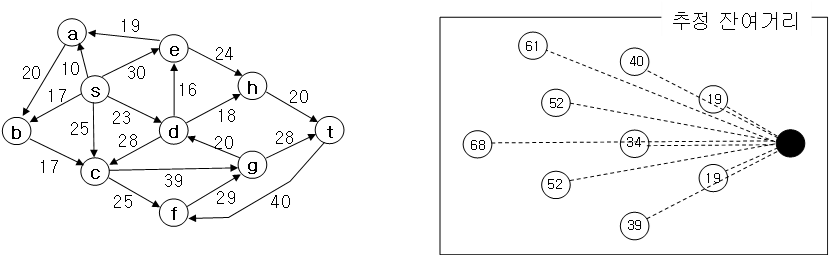

In [3]:
E = {"s":{"a":10, "b":17, "c":25, "d":23, "e":30},
            "a":{"b":20},
            "b":{"c":17},
            "c":{"f":25, "g":39},
            "d":{"c":28, "e":16, "h":18},
            "e":{"a":19, "h":24},
            "f":{"g":29},
            "g":{"d":20, "t":28},
            "h":{"t":20},
            "t":{"f":40}}
h = {"s":52, "a":61, "b":68, "c":52, "d":34,
        "e":40, "f":39, "g":19, "h":19, "t":0}

In [22]:
import math
def a_star(start, end):
    Q = list(E.keys()) # 방문할 수 있는(잔여) Q
    visited = [] # 방문순서
    prev = {} # 최단경로를 구하기 위한, 순서
    g={}
    f={}
    for node in Q: # 알려지지 않은 g, f 초기화
        g[node] = math.inf
        f[node] = math.inf
        #h[node]는 알려져있음
    
    g[start] = 0
    f[start] = g[start] + h[start] #### 만약 h값이 6없다면, 다엑스트라와 같다!
    
    while len(Q)>0:
        nearest_node = get_nearest_node(Q, f) # f가 가장 작은 노드 가져오기
        Q.remove(nearest_node)
        visited.append(nearest_node)
        
        if nearest_node == end:
            print('visited:',visited)
            break
        for node in E[nearest_node].keys(): 
            # 가장 작은(가까운) 노드와 연결되어있는 노드들에 대해
            if node in Q: # 아직 방문을 안해서 큐에 남아있고 
                if g[node] > g[nearest_node] + E[nearest_node][node]:
                    # 가까운 노드를 거쳐 가는 거리가 더 짧다면 업데이트
                    g[node] = g[nearest_node] + E[nearest_node][node]
                    f[node] = g[node] + h[node]
                    prev[node] = nearest_node 
                    # prev[타깃노드] = 이전노드

    return get_path(prev, end)
                    
def get_nearest_node(Q, f): # f값이 가장 작은 node를 return
    min = math.inf
    node = None
    for q in Q:
        if f[q] < min:
            min = f[q]
            node = q
    return node

def get_path(prev, target_node, path=[]):
    path.append(target_node) # 마지막 노드를 추가하고
    if target_node in prev: # 그 이전 노드들에 대해서 재귀로 추가한 뒤
        get_path(prev, prev[target_node], path)
    return list(reversed(path)) # 뒤집어서 return

print(a_star('a', 't'))
            
            

visited: ['a', 'b', 'c', 'g', 'f', 't']
['a', 'b', 'c', 'g', 't']
